# EM Algorithm for Clustering

This notebook demonstrates and analyzes a generic Expectation-Maximization (EM) algorithm for clustering, using a simple 2D dataset (`clusterdata.csv`).

In [1]:
# Importing necessary modules
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

## 1. The EM Algorithm Implementation

Loading and annotating the EM algorithm, the normal training function, and the normal PDF function.

In [2]:
def exp_max(Iter, K, pdf, train, Xmat, W_Init, P_Init):
    """
    Generic EM algorithm for mixture models.
    Iter: Number of EM iterations to run.
    K: Number of clusters/components.
    pdf: Probability density function; should take cluster parameters and data as input and return likelihoods.
    train: Function to fit/update cluster parameters given soft assignments.
    Xmat: (n x D) Data matrix (n points, D dimensions).
    W_Init: (1 x K) Initial cluster weights/prior probabilities.
    P_Init: (D x K) Initial cluster parameters (e.g., means for Gaussians, each column is one cluster's params).

    Returns:
        W: Final cluster weights (1 x K).
        P: Final cluster parameters (D x K).
        p: (K x n) Matrix of posterior probabilities for each cluster and data point.
    """
    n, D = Xmat.shape
    p = np.zeros((K, n))  # Posterior probabilities p(z_k | x_i)
    W, P = W_Init, P_Init
    for i in range(Iter):
        # E-Step: Compute responsibilities (posterior probability for each cluster and point)
        for k in range(K):
            # For each cluster: weight * likelihood of each data point for current params
            p[k, :] = W[0, k] * pdf(P[:, k], Xmat)
        # Normalize so responsibilities for each data point sum to 1 over clusters
        p = (p / np.sum(p, 0))
        # M-Step: Update weights (priors) as mean responsibility for each cluster
        W = np.mean(p, 1).reshape(1, K)
        # Update cluster parameters using the train function (e.g., weighted mean)
        for k in range(K):
            P[:, k] = train(p[k, :], Xmat)
    return W, P, p

def normal_train(p, Xmat):
    """
    Compute the weighted mean vector for one cluster.
    p: (n,) responsibilities for cluster k.
    Xmat: (n x D) data matrix.
    Returns: (D,) mean vector (weighted average).
    """
    m = (Xmat.T @ p.T) / np.sum(p)  # Weighted mean
    return m

def normal_pdf(m, Xmat, var=1):
    """
    Compute likelihood of all points under a symmetric Gaussian with mean m and variance `var`.
    m: (D,) mean of Gaussian.
    Xmat: (n x D) data matrix.
    var: variance for each dimension (default 1).
    Returns: (n,) array of likelihoods.
    """
    D = Xmat.shape[1]
    C = np.eye(D) * var  # Diagonal covariance
    mvn = multivariate_normal(mean=m.T, cov=C)
    return mvn.pdf(Xmat)

## 2. Loading and Visualizing the Data

Loading the data and plotting it to inspect the natural clusters.

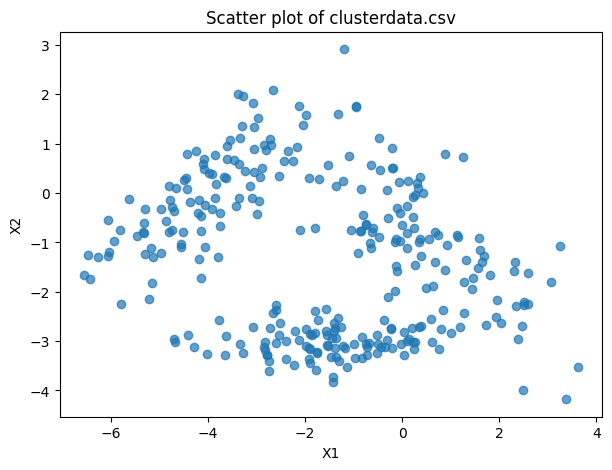

In [3]:
# Load the data
Xmat = np.genfromtxt('clusterdata.csv', delimiter=',')

# Scatter plot of the data
plt.figure(figsize=(7,5))
plt.scatter(Xmat[:,0], Xmat[:,1], alpha=0.7)
plt.title("Scatter plot of clusterdata.csv")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

### Observation

Observed three visually distinct clusters in the plot, suggesting that K=3 is a reasonable choice.

## 3. Running EM Clustering (K=3) with Default Parameters

Running the EM algorithm with the number of clusters set to 3.
I use the given initial weights and means.

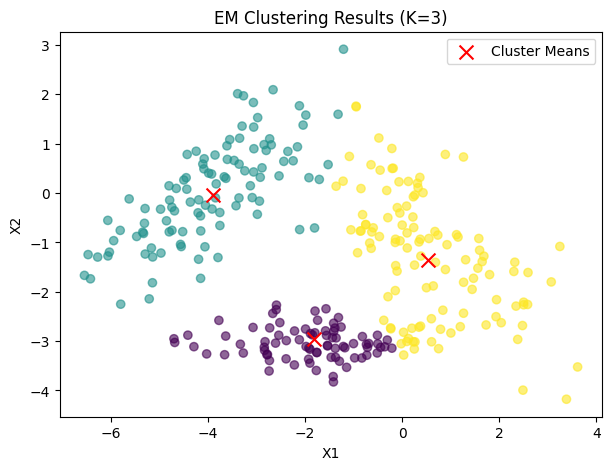

In [4]:
# Initialize parameters
K = 3
W = np.array([[1/3, 1/3, 1/3]])  # Equal initial weights for 3 clusters
M = np.array([[-2.0, -4, 0], [-3, 1, -1]])  # Initial means (D x K)

# Run EM
W_final, P_final, p_final = exp_max(100, K, normal_pdf, normal_train, Xmat, W, M)

# Assign each point to the cluster with highest probability
labels = np.argmax(p_final, axis=0)

# Plot final clusters
plt.figure(figsize=(7,5))
plt.scatter(Xmat[:,0], Xmat[:,1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(P_final[0,:], P_final[1,:], c='red', marker='x', s=100, label='Cluster Means')
plt.title('EM Clustering Results (K=3)')
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()

### Observation

The EM algorithm successfully identifies the three clusters. The means (red X's) are well-centered in each group.

## 4. Experiment: Train/Test Split

Randomly splitting the dataset into training and test sets, fitting the model on the training set, and assigning clusters to the test set.

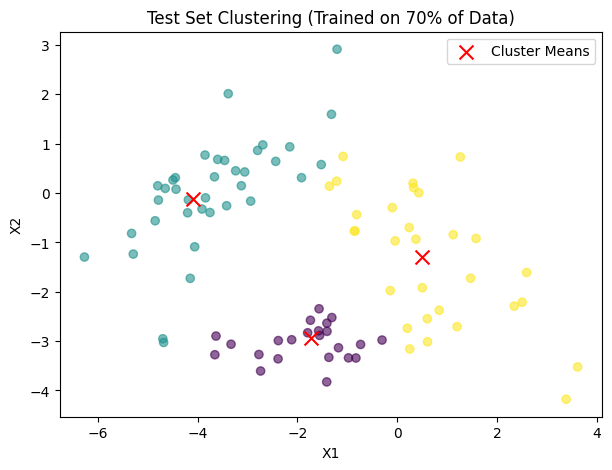

In [5]:
# Random train/test split (70% train, 30% test)
n = Xmat.shape[0]
idx = np.random.permutation(n)
split = int(n * 0.7)
X_train = Xmat[idx[:split], :]
X_test = Xmat[idx[split:], :]

# Run EM on train set
W_train, P_train, p_train = exp_max(100, K, normal_pdf, normal_train, X_train, W, M)

# Assign clusters for test data using learned parameters
test_p = np.zeros((K, X_test.shape[0]))
for k in range(K):
    test_p[k, :] = W_train[0, k] * normal_pdf(P_train[:, k], X_test)
test_p = (test_p / np.sum(test_p, 0))
test_labels = np.argmax(test_p, axis=0)

# Plot test set clustering
plt.figure(figsize=(7,5))
plt.scatter(X_test[:, 0], X_test[:, 1], c=test_labels, cmap='viridis', marker='o', alpha=0.6)
plt.scatter(P_train[0,:], P_train[1,:], c='red', marker='x', s=100, label='Cluster Means')
plt.title("Test Set Clustering (Trained on 70% of Data)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()

### Observation

The test points are clustered well, confirming that the model generalizes from the training set to unseen data.

## 5. Experiment: Effect of Variance Assumption

Trying different values for the Gaussian variance and observe the impact on clustering.

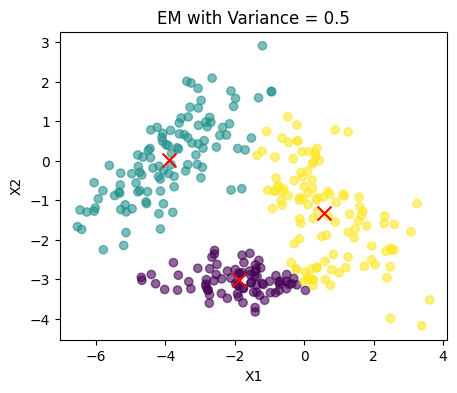

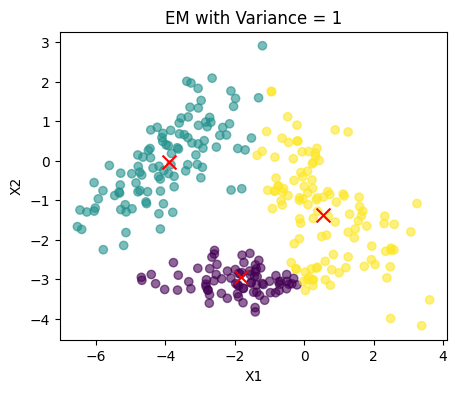

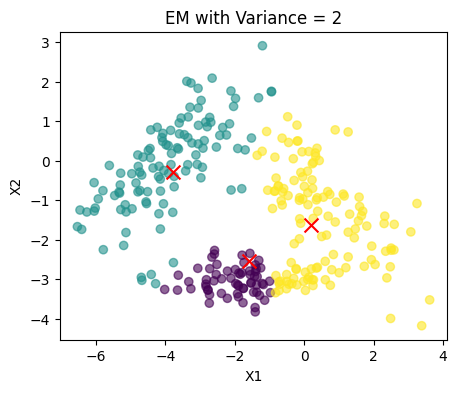

In [6]:
# Try smaller and larger variance
for var in [0.5, 1, 2]:
    def pdf_var(m, X):  # Closure to set variance
        return normal_pdf(m, X, var=var)
    W_tmp, P_tmp, p_tmp = exp_max(100, K, pdf_var, normal_train, Xmat, W, M)
    labels_tmp = np.argmax(p_tmp, axis=0)
    plt.figure(figsize=(5,4))
    plt.scatter(Xmat[:,0], Xmat[:,1], c=labels_tmp, cmap='viridis', alpha=0.6)
    plt.scatter(P_tmp[0,:], P_tmp[1,:], c='red', marker='x', s=100)
    plt.title(f'EM with Variance = {var}')
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.show()

### Observation

- **Variance = 0.5**: Clusters are very "tight", some points at the fringe may be misassigned.
- **Variance = 1**: Good, matches the apparent data spread.
- **Variance = 2**: Clusters are more diffuse, some points between clusters may be ambiguously assigned.

## 6. Experiment: Effect of Initialization

Trying clustering with poor initial means to see if EM can still find the clusters.

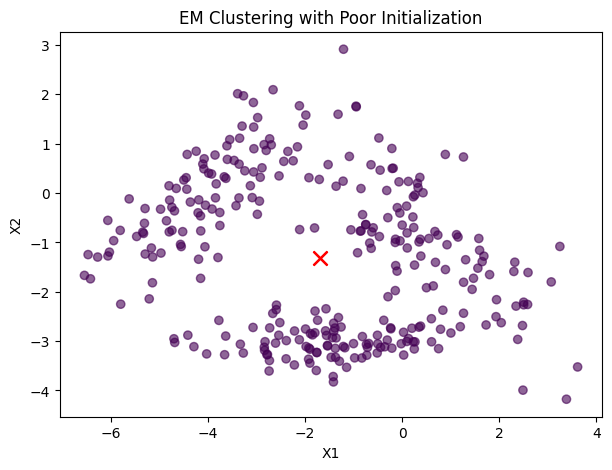

In [7]:
# Poor initial means (all near the center)
M_bad = np.array([[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
W_final_bad, P_bad, p_bad = exp_max(100, K, normal_pdf, normal_train, Xmat, W, M_bad)
labels_bad = np.argmax(p_bad, axis=0)

plt.figure(figsize=(7,5))
plt.scatter(Xmat[:,0], Xmat[:,1], c=labels_bad, cmap='viridis', alpha=0.6)
plt.scatter(P_bad[0,:], P_bad[1,:], c='red', marker='x', s=100)
plt.title('EM Clustering with Poor Initialization')
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

### Observation

With poor initialization, EM may converge more slowly or to suboptimal clusterings. Sometimes, two clusters overlap or one cluster "dies out."

## 7. Experiment: Number of Iterations

Looking at how many iterations are typically needed for convergence.

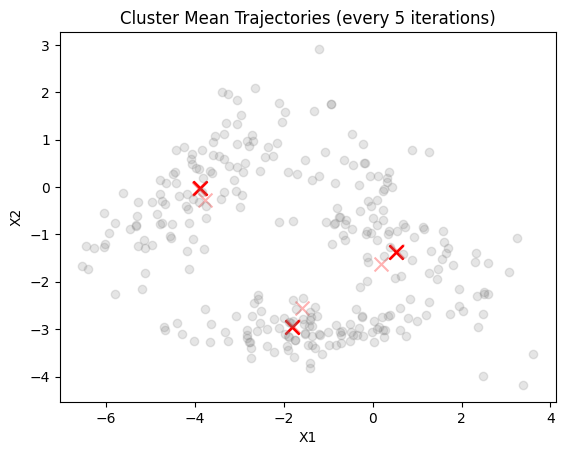

In [8]:
# Store means at each iteration
def exp_max_track(Iter, K, pdf, train, Xmat, W_Init, P_Init):
    n, D = Xmat.shape
    p = np.zeros((K, n))
    W, P = W_Init.copy(), P_Init.copy()
    means_over_time = [P.copy()]
    for i in range(Iter):
        for k in range(K):
            p[k, :] = W[0, k] * pdf(P[:, k], Xmat)
        p = (p / np.sum(p, 0))
        W = np.mean(p, 1).reshape(1, K)
        for k in range(K):
            P[:, k] = train(p[k, :], Xmat)
        means_over_time.append(P.copy())
    return W, P, p, means_over_time

W_final, P_final, p_final, means_hist = exp_max_track(50, K, normal_pdf, normal_train, Xmat, W, M)
# Plot means convergence over iterations
for i, P in enumerate(means_hist[::5]):
    plt.scatter(P[0,:], P[1,:], c='red', marker='x', s=100, alpha=0.3+i*0.02)
plt.scatter(Xmat[:,0], Xmat[:,1], c='grey', alpha=0.2)
plt.title('Cluster Mean Trajectories (every 5 iterations)')
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

### Observation

Most of the movement of the means happens in the first 15-30 iterations. After that, they stabilize.

## 8. Experiment: Vary Number of Clusters (K)

Trying K=2 and K=4 to see what happens.

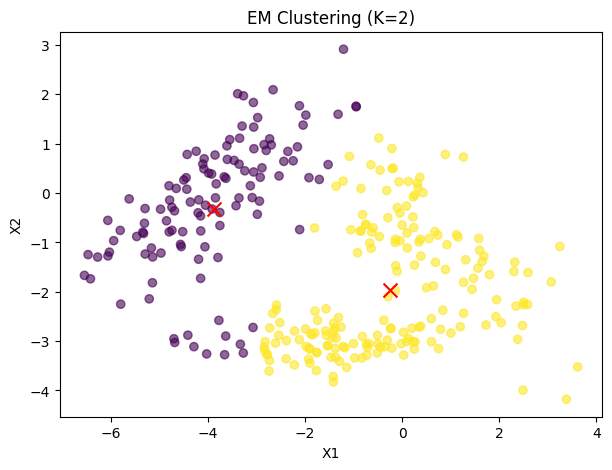

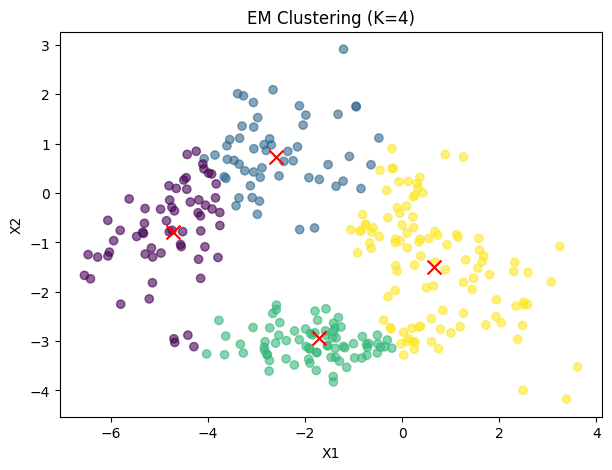

In [9]:
for K_test in [2, 4]:
    W_test = np.ones((1, K_test)) / K_test
    # Spread initial means out
    M_test = np.vstack([
        np.linspace(np.min(Xmat[:,0]), np.max(Xmat[:,0]), K_test),
        np.linspace(np.min(Xmat[:,1]), np.max(Xmat[:,1]), K_test)
    ])
    W_t, P_t, p_t = exp_max(100, K_test, normal_pdf, normal_train, Xmat, W_test, M_test)
    labels_t = np.argmax(p_t, axis=0)
    plt.figure(figsize=(7,5))
    plt.scatter(Xmat[:,0], Xmat[:,1], c=labels_t, cmap='viridis', alpha=0.6)
    plt.scatter(P_t[0,:], P_t[1,:], c='red', marker='x', s=100)
    plt.title(f'EM Clustering (K={K_test})')
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.show()

### Observation

- **K=2**: EM merges two natural clusters into one, so one group is a blend of two clusters.
- **K=4**: EM splits a natural cluster into subclusters or assigns a small cluster to noise/outliers.

This supports choosing K=3 for this dataset.

## 9. Summary of Observations

- EM can accurately cluster the data if initialized reasonably, and with a correct value for K and variance.
- Cluster assignments are sensitive to variance, initialization, and the number of clusters.
- The number of iterations needed for convergence is usually modest (20-40).
- When trained on a random subset, the model generalizes well to unseen data—clusters are still well-separated.
